# Deep Learning with Pytorch: Street View House Number Prediction








# Libraries and Setup



## Import the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

## Set up GPU capabilities

The cell below sets up a CUDA device to use with torch, if available to you.



In [2]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0+cu121
cuda:0


In [3]:
device

device(type='cuda', index=0)

# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch`



The dataset is called Street View House Numbers (or SVHN). The dataset consists of images of **house numbers**, taken from Google Street View. There are 10 classes, one for each digit (0-9).

We would be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network (FNN)
3.   Convolutional Neural Network (CNN)

And analyze the difference between these models by looking at the test accuracy and loss.

## 1.1 Pytorch Dataset



### 1.1.1 Instantiate Dataset (for train/test dataset)

1.   Resize the image to 32 by 32 $\to$ just to make sure they are really have size $32$x$32$
2.   Convert the images to Tensor
3.   Normalize the Tensor using, the means `[0.485, 0.456, 0.406]` and standard deviations `[0.229, 0.224, 0.225]`. We do this because these are color images, and so there are **three** color channels for which we need to normalize (r, g, b).


In [4]:
from torchvision import transforms
scale = 32

transforms = transforms.Compose([
    transforms.Resize([scale, scale]), #resize
    transforms.ToTensor(), #convert to tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

In [5]:
train_dataset = torchvision.datasets.SVHN(root = './data', split = 'train', transform = transforms, download = True)
test_dataset = torchvision.datasets.SVHN(root = './data', split = 'test', transform = transforms, download = True)

100%|██████████| 182040794/182040794 [00:28<00:00, 6388694.19it/s]


100%|██████████| 64275384/64275384 [00:14<00:00, 4485995.77it/s]


In [6]:
print(len(train_dataset))
print(len(test_dataset))

73257
26032


## 1.2 Summarizing our Dataset



### 1.2.1 Looking at the distribution of labels



In [7]:
all_train_labels = [label for (_, label) in train_dataset]

train_num_labels = len(set(all_train_labels))

train_dataset_dict = {}
for x in all_train_labels:
  if x in train_dataset_dict:
    train_dataset_dict[x] += 1
  else:
    train_dataset_dict[x] = 1

train_loader_bar_plot = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = True, num_workers = 0)

print(train_dataset_dict)

{1: 13861, 9: 4659, 2: 10585, 3: 8497, 5: 6882, 8: 5045, 7: 5595, 4: 7458, 6: 5727, 0: 4948}


In [8]:
all_test_labels = [label for (_, label) in test_dataset]

test_num_labels = len(set(all_test_labels))

test_dataset_dict = {}
for x in all_test_labels:
  if x in test_dataset_dict:
    test_dataset_dict[x] += 1
  else:
    test_dataset_dict[x] = 1

test_loader_bar_plot = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True, num_workers = 0)

print(test_dataset_dict)

{5: 2384, 2: 4149, 1: 5099, 0: 1744, 6: 1977, 9: 1595, 8: 1660, 3: 2882, 4: 2523, 7: 2019}


### 1.2.2 Visualize through bar charts



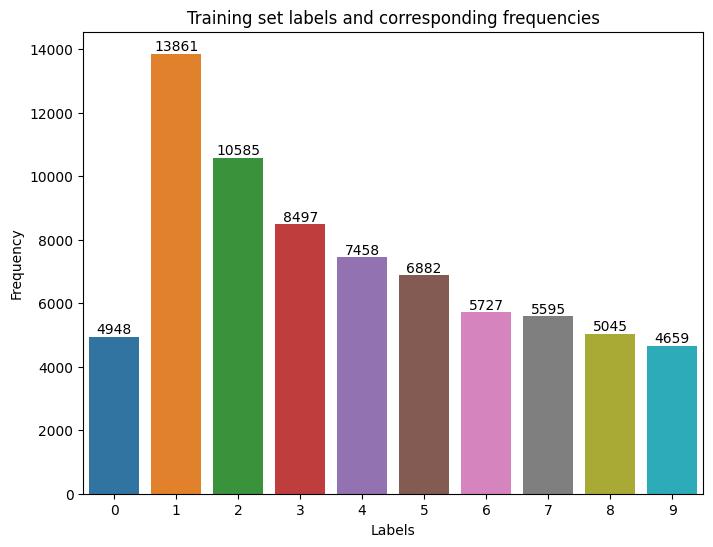

In [9]:
data = pd.DataFrame(list(train_dataset_dict.items()), columns = ['Label', 'Frequency'])
plt.figure(figsize=(8, 6))
ax = sns.barplot(x = 'Label', y = 'Frequency', data = data)
ax.bar_label(ax.containers[0])
plt.title('Training set labels and corresponding frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

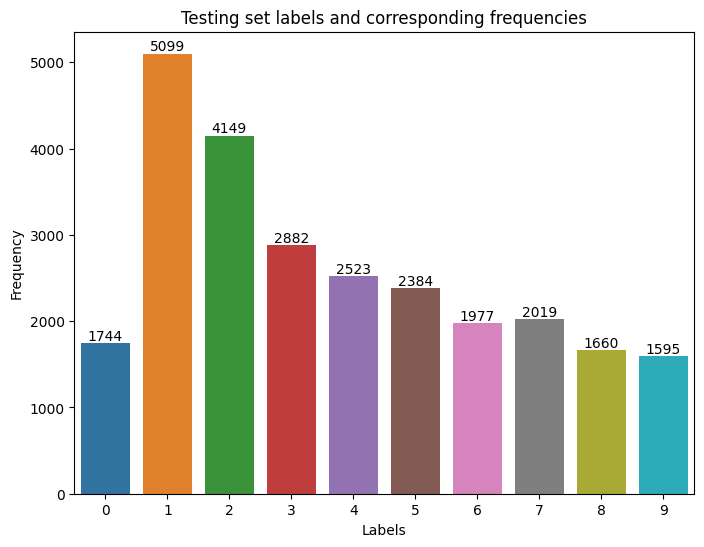

In [10]:
data = pd.DataFrame(list(test_dataset_dict.items()), columns = ['Label', 'Frequency'])
plt.figure(figsize=(8, 6))
ax = sns.barplot(x = 'Label', y = 'Frequency', data = data)
ax.bar_label(ax.containers[0])
plt.title('Testing set labels and corresponding frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

### 1.2.3 Have equal spread of labels




In [11]:
torch.manual_seed(42)

train_indices = []

train_count_dict = {label: 0 for label in range(10)}

for idx, (image, label) in enumerate(train_dataset):
  if (train_count_dict[label] < 3000):
    train_count_dict[label] += 1
    train_indices.append(idx)

In [12]:
torch.manual_seed(42)

test_indices = []

test_count_dict = {label: 0 for label in range(10)}

for idx, (image, label) in enumerate(test_dataset):
  if (test_count_dict[label] < 500):
    test_count_dict[label] += 1
    test_indices.append(idx)


In [13]:
from torch.utils.data import Subset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

In [14]:
train_subset_dict = dict()
test_subset_dict = dict()

for (_, label) in train_subset:
  if label in train_subset_dict:
    train_subset_dict[label] += 1
  else:
    train_subset_dict[label] = 1

for (_, label) in test_subset:
  if label in test_subset_dict:
    test_subset_dict[label] += 1
  else:
    test_subset_dict[label] = 1


In [15]:
batch = 64

train_loader = DataLoader(train_subset, batch_size = batch, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_subset, batch_size = batch, shuffle = True, num_workers = 0)

# **Part 2:** Classification Models


## 2.1 Multimonial Logical Logistic Regression - Baseline



### 2.1.1 Logistic Regression Model Architecture



In [16]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.weight = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.weight(x)
        return outputs

In [17]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (weight): Linear(in_features=3072, out_features=10, bias=True)
)

### 2.1.2 Training Logistic Regression Model


In [18]:
%%time
logreg = LogReg().to(device='cuda:0')
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = logreg(inputs)
      predicted = outputs.argmax(dim=1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_log.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_log.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.294868260812658, Accuracy = 15.456666666666667
The loss for Epoch 1 is: 2.2512056375109055, Accuracy = 19.833333333333332
The loss for Epoch 2 is: 2.2364569660951332, Accuracy = 21.19
The loss for Epoch 3 is: 2.2264728881656994, Accuracy = 22.26
The loss for Epoch 4 is: 2.2200731529609987, Accuracy = 22.893333333333334
The loss for Epoch 5 is: 2.2169547172497586, Accuracy = 23.053333333333335
The loss for Epoch 6 is: 2.2112679328999794, Accuracy = 23.82
The loss for Epoch 7 is: 2.2074272693601498, Accuracy = 24.276666666666667
The loss for Epoch 8 is: 2.207447666603365, Accuracy = 23.976666666666667
The loss for Epoch 9 is: 2.201991613485666, Accuracy = 24.406666666666666
CPU times: user 1min 49s, sys: 816 ms, total: 1min 49s
Wall time: 2min 7s


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression


Text(0.5, 1.0, 'Training Accuracy vs Epochs for Logistic Regression')

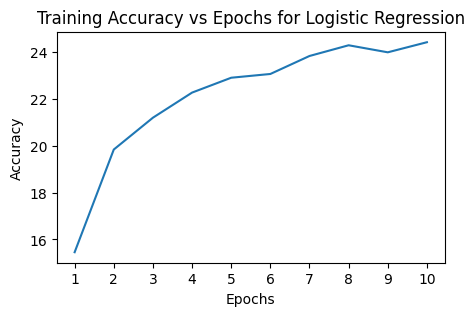

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.DataFrame(acc_LIST_log, columns = ['accuracy'])

plt.figure(figsize=(5, 3))
sns.lineplot(x = range(1, 11), y = 'accuracy', data = df)
plt.xticks(range(1, 11))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs for Logistic Regression')

### 2.1.4 Logistic Regression Model Accuracy


In [20]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        outputs = logreg(images)
        predicted = outputs.argmax(dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc_log = torch.tensor(100 * correct / total)

print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 19.34000015258789


## 2.2 Feedforward Neural Networks



### 2.2.1 Feedforward Neural Network Model Architecture

In [21]:
def raw_sample_to_red(sample):
  # convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the red values
  return sample[:, 0, :, :].unsqueeze(1)
  pass

def raw_sample_to_grayscale(sample):
  # convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the grey scale values
  return sample.mean(dim = 1).unsqueeze(1)
  pass


### 2.2.2 Feedforward Neural Network Model Architecture




In [22]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        hidden_feat = self.relu(self.linear1(x))
        outputs = self.linear2(hidden_feat)

        return outputs

In [23]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

### 2.2.3 Training FNN Model


In [24]:
%%time


fnn_red = FNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn_red.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_red = []
loss_LIST_FNN_red = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = fnn_red(raw_sample_to_red(inputs))
      predicted = outputs.argmax(dim = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_FNN_red.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_FNN_red.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))



The loss for Epoch 0 is: 2.0135665745623332, Accuracy = 37.42
The loss for Epoch 1 is: 1.48142225096729, Accuracy = 59.95333333333333
The loss for Epoch 2 is: 1.2419035458869772, Accuracy = 65.32
The loss for Epoch 3 is: 1.1195390017302052, Accuracy = 68.26333333333334
The loss for Epoch 4 is: 1.0408877373250054, Accuracy = 70.06
The loss for Epoch 5 is: 0.9799431406104488, Accuracy = 71.54333333333334
The loss for Epoch 6 is: 0.9300214896069915, Accuracy = 73.08
The loss for Epoch 7 is: 0.8869746172351878, Accuracy = 74.17333333333333
The loss for Epoch 8 is: 0.8479885664830076, Accuracy = 75.38666666666667
The loss for Epoch 9 is: 0.8148379196236128, Accuracy = 76.36666666666666
CPU times: user 1min 47s, sys: 532 ms, total: 1min 47s
Wall time: 2min 4s


In [25]:
%%time

fnn_gray = FNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn_gray.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_gray = []
loss_LIST_FNN_gray = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = fnn_gray(raw_sample_to_grayscale(inputs))
      predicted = outputs.argmax(dim = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_FNN_gray.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_FNN_gray.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.0429599630807256, Accuracy = 36.70333333333333
The loss for Epoch 1 is: 1.4900320976781947, Accuracy = 61.166666666666664
The loss for Epoch 2 is: 1.2286106598402646, Accuracy = 66.41666666666667
The loss for Epoch 3 is: 1.100222826766561, Accuracy = 69.09
The loss for Epoch 4 is: 1.016903556232005, Accuracy = 71.19
The loss for Epoch 5 is: 0.9527662138440716, Accuracy = 72.93333333333334
The loss for Epoch 6 is: 0.9028025063624514, Accuracy = 74.41333333333333
The loss for Epoch 7 is: 0.859273141126897, Accuracy = 75.38
The loss for Epoch 8 is: 0.8218277134874991, Accuracy = 76.49
The loss for Epoch 9 is: 0.7890122014322261, Accuracy = 77.57
CPU times: user 1min 41s, sys: 520 ms, total: 1min 41s
Wall time: 1min 51s


### 2.2.4 Feed Forward Network on Raw Inputs Architecture


In [26]:
class FNN_RAW(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3072, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        hidden_feat = self.relu(self.linear1(x))
        outputs = self.linear2(hidden_feat)

        return outputs

In [27]:
FNN_RAW()

FNN_RAW(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3072, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [28]:
%%time

fnn = FNN_RAW().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = fnn(inputs)
      predicted = outputs.argmax(dim = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_FNN.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 1.8007053490132412, Accuracy = 44.486666666666665
The loss for Epoch 1 is: 1.2172253021299204, Accuracy = 65.46333333333334
The loss for Epoch 2 is: 1.0385899323898593, Accuracy = 69.94
The loss for Epoch 3 is: 0.9349734237961678, Accuracy = 72.85333333333334
The loss for Epoch 4 is: 0.8634018833194969, Accuracy = 74.69333333333333
The loss for Epoch 5 is: 0.8054054465883577, Accuracy = 76.56
The loss for Epoch 6 is: 0.7551928737651564, Accuracy = 78.06333333333333
The loss for Epoch 7 is: 0.7146448535578591, Accuracy = 79.37
The loss for Epoch 8 is: 0.6801092510919835, Accuracy = 80.34
The loss for Epoch 9 is: 0.6485053011095092, Accuracy = 81.28
CPU times: user 2min 8s, sys: 647 ms, total: 2min 8s
Wall time: 2min 38s


### 2.2.5 Plotting Training Accuracy vs Epochs FNN



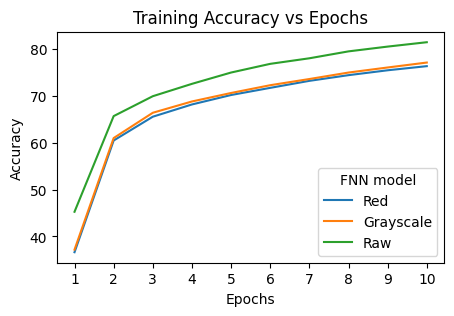

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
df = pd.DataFrame({'red_accuracy': acc_LIST_FNN_red, 'grayscale_accuracy': acc_LIST_FNN_gray, 'raw_accuracy': acc_LIST_FNN})
x_range = range(1, 11)
sns.lineplot(x = x_range, y = 'red_accuracy', data = df, label = 'Red')
sns.lineplot(x = x_range, y = 'grayscale_accuracy', data = df, label = 'Grayscale')
sns.lineplot(x = x_range, y = 'raw_accuracy', data = df, label = 'Raw')
plt.legend(title = 'FNN model')
plt.xticks(x_range)
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


### 2.2.6 FNN Model Accuracy


In [29]:
total = 0
correct_fnn = 0
correct_fnn_red = 0
correct_fnn_gray = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        outputs_red = fnn_red(raw_sample_to_red(images))
        outputs_gray = fnn_gray(raw_sample_to_grayscale(images))
        outputs_raw = fnn(images)
        # Get the prediction using argmax
        predicted_red = outputs_red.argmax(dim = 1)
        predicted_gray = outputs_gray.argmax(dim = 1)
        predicted_raw = outputs_raw.argmax(dim = 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct_fnn_red += (predicted_red == labels).sum().item()
        correct_fnn_gray += (predicted_gray == labels).sum().item()
        correct_fnn += (predicted_raw == labels).sum().item()

# Calculate test accuracy for FNN
test_acc_FNN_red = torch.tensor(100 * correct_fnn_red / total)
test_acc_FNN_gray = torch.tensor(100 * correct_fnn_gray / total)
test_acc_FNN = torch.tensor(100 * correct_fnn / total)

print('Test Accuracy (Red Values Only): ' + str(test_acc_FNN_red.item()))
print('Test Accuracy (Grayscale Values Only): ' + str(test_acc_FNN_gray.item()))
print('Test Accuracy (All Values): ' + str(test_acc_FNN.item()))


Test Accuracy (Red Values Only): 70.5
Test Accuracy (Grayscale Values Only): 71.45999908447266
Test Accuracy (All Values): 74.22000122070312


##2.3 Convolutional Neural Networks




### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers

In [30]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  return int((input_dim + (2 * padding) - (kernel_size - 1) - 1) / stride + 1)

### 2.3.1 Creating custom Convolutional Neural Network Architecture

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.mp = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        size = feature_map_dim(32, 1, 3, 1)
        size = feature_map_dim(size, 0, 2, 2)
        size = feature_map_dim(size, 1, 3, 1)
        size = feature_map_dim(size, 0, 2, 2)
        self.fc = nn.Linear(32 * size * size, out_features=10)

    def forward(self, x):
      outputs = self.conv(x)
      outputs = self.relu(outputs)
      outputs = self.mp(outputs)
      outputs = self.conv2(outputs)
      outputs = self.relu(outputs)
      outputs = self.mp(outputs)
      outputs = self.flatten(outputs)
      outputs = self.fc(outputs)
      return outputs

In [32]:
CNN()

CNN(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

### 2.3.2 Training CNN Model


In [33]:
%%time

cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = cnn(inputs)
      predicted = outputs.argmax(dim = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_CNN.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.2480245317731584, Accuracy = 20.196666666666665
The loss for Epoch 1 is: 1.7056160316284277, Accuracy = 52.086666666666666
The loss for Epoch 2 is: 1.1134871166906377, Accuracy = 69.56666666666666
The loss for Epoch 3 is: 0.8995278639071531, Accuracy = 75.02
The loss for Epoch 4 is: 0.8023727099016023, Accuracy = 77.72666666666667
The loss for Epoch 5 is: 0.7447767996076328, Accuracy = 79.09666666666666
The loss for Epoch 6 is: 0.7055059011811132, Accuracy = 80.45333333333333
The loss for Epoch 7 is: 0.6770311471368713, Accuracy = 80.92
The loss for Epoch 8 is: 0.6556030265939261, Accuracy = 81.77
The loss for Epoch 9 is: 0.6377947671072823, Accuracy = 82.02
CPU times: user 1min 47s, sys: 618 ms, total: 1min 47s
Wall time: 2min 7s


### 2.3.3 Plotting Training Accuracy vs Epochs CNN



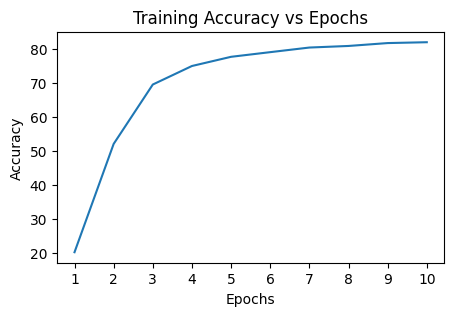

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (5, 3))
x_range = range(1, 11)
sns.lineplot(x = x_range, y = acc_LIST_CNN)

plt.xticks(x_range)
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### 2.3.4 CNN Model Test Accuracy



In [35]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        output = cnn(images)
        prediction = output.argmax(dim=1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

test_acc_CNN = torch.tensor(100 * correct / total)

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 78.0999984741211


### 2.3.5 CNN Hyperparameter Tuning

Hyperparameters tuned: `learning rate`, `beta1`, `beta2` and `number of fully connected layers`.


In [36]:
class CNNTuned(nn.Module):
    def __init__(self, ff_layers = 3):
        super().__init__()
        self.num_ff_layers = ff_layers
        self.conv = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.mp = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        size = feature_map_dim(32, 1, 3, 1)
        size = feature_map_dim(size, 0, 2, 2)
        size = feature_map_dim(size, 1, 3, 1)
        size = feature_map_dim(size, 0, 2, 2)

        flattened_size = 32 * size * size
        self.ff_layers = nn.ModuleList()

        for i in range(self.num_ff_layers - 1):
          self.ff_layers.append(nn.Linear(flattened_size, flattened_size // 2))
          flattened_size = flattened_size // 2
        self.ff_layers.append(nn.Linear(in_features=flattened_size, out_features=10))

    def forward(self, x):
      outputs = self.conv(x)
      outputs = self.relu(outputs)
      outputs = self.mp(outputs)
      outputs = self.conv2(outputs)
      outputs = self.relu(outputs)
      outputs = self.mp(outputs)
      outputs = self.flatten(outputs)

      for i, fc in enumerate(self.ff_layers):
            outputs = fc(outputs)
            if i < self.num_ff_layers - 1:
                outputs = self.relu(outputs)
      return outputs


In [37]:
from sklearn.model_selection import ParameterGrid

In [38]:
param_grid  = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'betas': [(0.9, 0.999), (0.95, 0.999), (0.9, 0.995)],
    'num_fc' : [1, 2, 3]
}

pgrid = ParameterGrid(param_grid)

num_epochs = 5

In [39]:
def cnn_train_and_evaluate(model, train_loader, optimizer, num_epochs):
  criterion = nn.CrossEntropyLoss()
  best_accuracy = 0
  for epochs in range(num_epochs):
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = outputs.argmax(dim = 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    if epoch_accuracy > best_accuracy:
          best_accuracy = epoch_accuracy

  return best_accuracy

best_params = None
best_accuracy = 0;

for params in pgrid:
    model = CNNTuned(ff_layers=params['num_fc']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], betas=params['betas'])
    accuracy = cnn_train_and_evaluate(model, train_loader, optimizer, num_epochs)
    print(str(params) + " accuracy : " + str(accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

{'betas': (0.9, 0.999), 'learning_rate': 0.001, 'num_fc': 1} accuracy : 86.75
{'betas': (0.9, 0.999), 'learning_rate': 0.001, 'num_fc': 2} accuracy : 92.62333333333333
{'betas': (0.9, 0.999), 'learning_rate': 0.001, 'num_fc': 3} accuracy : 92.99666666666667
{'betas': (0.9, 0.999), 'learning_rate': 0.0005, 'num_fc': 1} accuracy : 85.40666666666667
{'betas': (0.9, 0.999), 'learning_rate': 0.0005, 'num_fc': 2} accuracy : 90.85666666666667
{'betas': (0.9, 0.999), 'learning_rate': 0.0005, 'num_fc': 3} accuracy : 91.41666666666667
{'betas': (0.9, 0.999), 'learning_rate': 0.0001, 'num_fc': 1} accuracy : 77.58666666666667
{'betas': (0.9, 0.999), 'learning_rate': 0.0001, 'num_fc': 2} accuracy : 85.51
{'betas': (0.9, 0.999), 'learning_rate': 0.0001, 'num_fc': 3} accuracy : 85.89
{'betas': (0.95, 0.999), 'learning_rate': 0.001, 'num_fc': 1} accuracy : 86.24666666666667
{'betas': (0.95, 0.999), 'learning_rate': 0.001, 'num_fc': 2} accuracy : 90.60333333333334
{'betas': (0.95, 0.999), 'learning_rat

In [40]:
print(best_params)
print(best_accuracy)

{'betas': (0.9, 0.995), 'learning_rate': 0.001, 'num_fc': 3}
94.35666666666667


In [41]:
%%time

cnn = CNNTuned(ff_layers=best_params['num_fc']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=best_params['learning_rate'], betas=best_params['betas'])
epoch = 10

acc_LIST_CNN_TUNE = []
loss_LIST_CNN_TUNE = []

for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = cnn(inputs)
      predicted = outputs.argmax(dim = 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  acc_LIST_CNN_TUNE.append(accuracy)
  epoch_loss = running_loss / len(train_loader)
  loss_LIST_CNN_TUNE.append(epoch_loss)

  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 1.2946518076254105, Accuracy = 55.08
The loss for Epoch 1 is: 0.5425456481765328, Accuracy = 83.46666666666667
The loss for Epoch 2 is: 0.4201240964027356, Accuracy = 87.13333333333334
The loss for Epoch 3 is: 0.3373247516085344, Accuracy = 89.59666666666666
The loss for Epoch 4 is: 0.2647267627928938, Accuracy = 91.98333333333333
The loss for Epoch 5 is: 0.20242195635207935, Accuracy = 93.86666666666666
The loss for Epoch 6 is: 0.15687441115360906, Accuracy = 95.30666666666667
The loss for Epoch 7 is: 0.11686439366578293, Accuracy = 96.41
The loss for Epoch 8 is: 0.09626041408548795, Accuracy = 96.87333333333333
The loss for Epoch 9 is: 0.07780415833349834, Accuracy = 97.5
CPU times: user 1min 40s, sys: 439 ms, total: 1min 40s
Wall time: 1min 41s


In [47]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)
        output = cnn(images)
        prediction = output.argmax(dim = 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

test_acc_CNN = torch.tensor(100 * correct / total)

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 84.44000244140625


## 2.4. Reflection



Let's compare the model performance:

From the test accuracies, we can see that FNN works better than Logistic Regression, and CNN works even better than FNN.

In [43]:
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 19.34000015258789
Test Accuracy for FNN: 74.22000122070312
Test Accuracy for CNN: 84.44000244140625


## 2.5 Confusion Matrix






### 2.5.1 Create confusion matrix


In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def cm_generator(test_loader):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = outputs.argmax(dim = 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_preds)

  cm_df = pd.DataFrame(cm)

  return cm_df

confusion_matrix_df = cm_generator(test_loader)

### 2.5.2 Visualizing Confusion Matrix


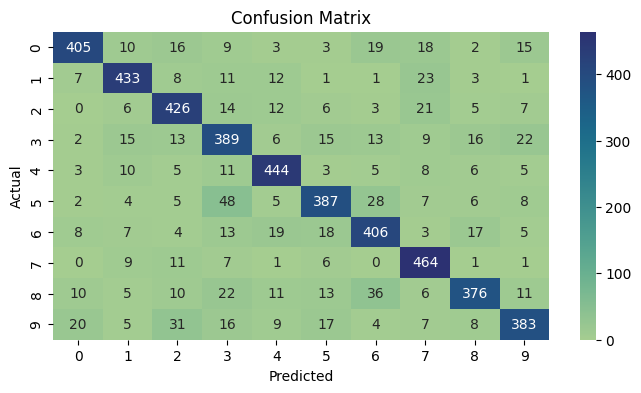

In [45]:
fig = plt.figure(figsize = (8, 4))
sns.heatmap(confusion_matrix_df, annot = True, fmt = "g", cmap = "crest")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()